In [1]:
import pandas as pd
from pathlib import Path
import subprocess
import re

In [2]:
ROOT = Path("../")
LOG_PATH = ROOT / "batch-gemini-image-text-production" / "target-pages.tsv"

In [3]:
df = pd.read_csv(LOG_PATH, sep="\t")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   year          80 non-null     int64 
 1   page_begin    80 non-null     int64 
 2   page_end      80 non-null     int64 
 3   note          80 non-null     object
 4   LOCALISATION  80 non-null     object
dtypes: int64(3), object(2)
memory usage: 3.3+ KB


In [4]:
df.head()

,year,page_begin,page_end,note,LOCALISATION
0,1887,22,56,DOCTEURS EN MÉDECINE ET EN CHIRURGIE,PARIS
1,1887,60,192,DOCTEURS,DEPARTEMENT ET COLONIES
2,1887,198,200,OFFICIERS DE SANTÉ,PARIS
3,1887,206,236,OFFICIERS DE SANTÉ,DEPARTEMENTS ET COLONIES
4,1888,60,89,DOCTEURS EN MÉDECINE ET EN CHIRURGIE,PARIS


In [5]:
sorted_pairs = []
for item in df.to_dict(orient="records"):
    year = item['year']
    for page_num in range(item['page_begin'], item['page_end'] + 1):
        sorted_pairs.append((str(year), str(page_num).zfill(4)))
sorted_pairs.sort()

In [6]:
len(sorted_pairs)

4166

In [8]:
# Run tesseract
def extract_text(img_path, output_path):
    language = 'fra'
    psm = '3' # Page segmentation mode (default: 3 for automatic page segmentation)
    cmd = [
        'tesseract', str(img_path), str(output_path.with_suffix('')),
        '-l', language, '--psm', psm
    ]
    result = subprocess.run(cmd, capture_output=True, text=True)
    if result.returncode == 0:
        print(f"✓ Success: {output_path}")
        return True
    else:
        print(f"✗ Failed: {img_path.name}")
        print(f"  Error: {result.stderr.strip()}")
        return False

In [12]:
original_text_dict = {}
for year, page in sorted_pairs:
    file_path = ROOT / "rosenwald-original-ocr" / f"{year}" / f"{year}-page-{page}.txt"
    text = file_path.read_text(encoding="utf-8")
    original_text_dict[(year, page)] = text

In [13]:
no_original_ocr_pairs = [(year, page) for (year, page), text in original_text_dict.items()  if year == "1899" or year == "1902" or year == "1903"]
len(no_original_ocr_pairs)

708

In [10]:
from joblib import Parallel, delayed
from pathlib import Path

def _worker(year, page, root_str):
    root = Path(root_str)

    img_path = root / "rosenwald-images" / year / f"{year}-page-{page}.png"
    output_path = root / "rosenwald-tesseract-ocr" / year / f"{year}-page-{page}.txt"

    if output_path.exists():
        return ("skipped", year, page)

    output_path.parent.mkdir(parents=True, exist_ok=True)
    extract_text(img_path, output_path)
    return ("done", year, page)

root_str = str(ROOT)

tasks = []
for year, page in no_original_ocr_pairs:
    out = ROOT / "rosenwald-tesseract-ocr" / year / f"{year}-page-{page}.txt"
    if not out.exists():
        tasks.append((year, page))

results = Parallel(n_jobs=8, backend="loky", batch_size=20)(
    delayed(_worker)(year, page, root_str) for year, page in tasks
)

✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0069.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0057.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0063.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0059.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0067.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0061.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0065.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0055.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0060.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0070.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0066.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0062.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0058.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0068.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0064.txt
✓ Success: ../rosenwald-tesseract-ocr/1899/1899-page-0056.txt
✓ Succes

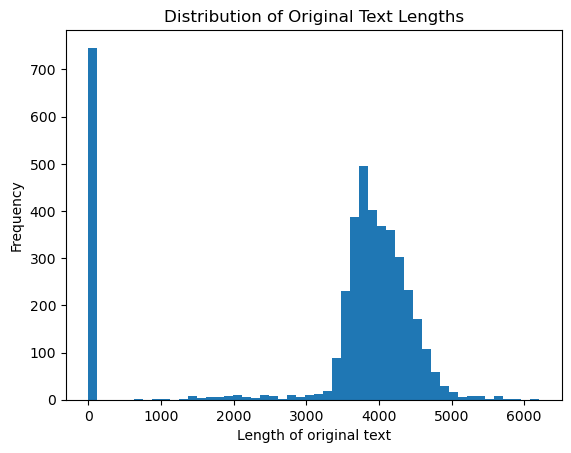

In [66]:
# length distribution of original texts in histogram, labelled with year and page
lengths = [len(text) for text in original_text_dict.values()]
import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)
plt.xlabel("Length of original text")
plt.ylabel("Frequency")
plt.title("Distribution of Original Text Lengths")
plt.show()


In [14]:
for year, page in no_original_ocr_pairs:
    file_path = ROOT / "rosenwald-tesseract-ocr" / f"{year}" / f"{year}-page-{page}.txt"
    text = file_path.read_text(encoding="utf-8")
    original_text_dict[(year, page)] = text

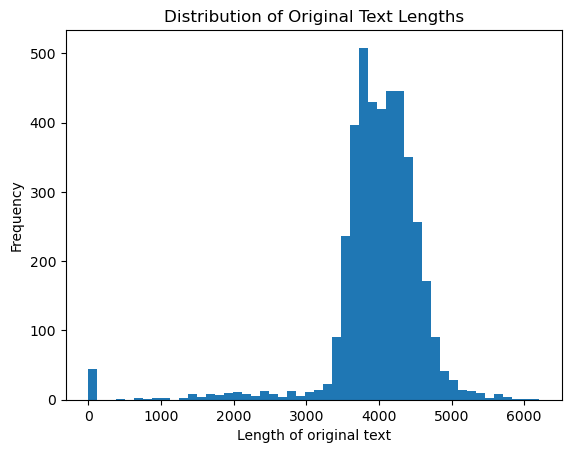

In [24]:
# length distribution of original texts in histogram, labelled with year and page
lengths = [len(text) for text in original_text_dict.values()]
import matplotlib.pyplot as plt
plt.hist(lengths, bins=50)
plt.xlabel("Length of original text")
plt.ylabel("Frequency")
plt.title("Distribution of Original Text Lengths")
plt.show()


In [25]:
# filter out the years and pages with original text length < 3000
filtered_pairs = {(year, page) : text for (year, page), text in original_text_dict.items() if len(text) < 500 and len(text) > 0}
len(filtered_pairs)

22

In [26]:
filtered_pairs.keys()

dict_keys([('1890', '0098'), ('1892', '0286'), ('1896', '0108'), ('1896', '0130'), ('1896', '0431'), ('1897', '0110'), ('1900', '0319'), ('1900', '0323'), ('1900', '0424'), ('1901', '0098'), ('1901', '0104'), ('1901', '0108'), ('1901', '0326'), ('1901', '0349'), ('1903', '0466'), ('1904', '0128'), ('1904', '0372'), ('1904', '0397'), ('1904', '0399'), ('1904', '0446'), ('1904', '0464'), ('1904', '0470')])

In [27]:
zero_length_pairs = [(year, page) for (year, page), text in original_text_dict.items() if len(text) == 0]

In [28]:
len(zero_length_pairs)

23

In [29]:
zero_length_pairs

[('1887', '0046'),
 ('1887', '0047'),
 ('1887', '0086'),
 ('1887', '0087'),
 ('1887', '0124'),
 ('1887', '0125'),
 ('1887', '0150'),
 ('1887', '0176'),
 ('1887', '0177'),
 ('1896', '0432'),
 ('1899', '0054'),
 ('1903', '0076'),
 ('1903', '0080'),
 ('1903', '0084'),
 ('1903', '0088'),
 ('1903', '0133'),
 ('1904', '0373'),
 ('1904', '0374'),
 ('1904', '0375'),
 ('1904', '0507'),
 ('1904', '0508'),
 ('1904', '0509'),
 ('1904', '0510')]

In [30]:
original_text_dict.keys()

dict_keys([('1887', '0022'), ('1887', '0023'), ('1887', '0024'), ('1887', '0025'), ('1887', '0026'), ('1887', '0027'), ('1887', '0028'), ('1887', '0029'), ('1887', '0030'), ('1887', '0031'), ('1887', '0032'), ('1887', '0033'), ('1887', '0034'), ('1887', '0035'), ('1887', '0036'), ('1887', '0037'), ('1887', '0038'), ('1887', '0039'), ('1887', '0040'), ('1887', '0041'), ('1887', '0042'), ('1887', '0043'), ('1887', '0044'), ('1887', '0045'), ('1887', '0046'), ('1887', '0047'), ('1887', '0048'), ('1887', '0049'), ('1887', '0050'), ('1887', '0051'), ('1887', '0052'), ('1887', '0053'), ('1887', '0054'), ('1887', '0055'), ('1887', '0056'), ('1887', '0060'), ('1887', '0061'), ('1887', '0062'), ('1887', '0063'), ('1887', '0064'), ('1887', '0065'), ('1887', '0066'), ('1887', '0067'), ('1887', '0068'), ('1887', '0069'), ('1887', '0070'), ('1887', '0071'), ('1887', '0072'), ('1887', '0073'), ('1887', '0074'), ('1887', '0075'), ('1887', '0076'), ('1887', '0077'), ('1887', '0078'), ('1887', '0079'),

In [31]:
import csv

def escape_text(text):
    if text is None:
        return ""
    text = text.replace("\r\n", "\n").replace("\r", "\n")
    text = text.replace("\n", r"\n")
    text = text.replace("\t", r"\t")  # optional but recommended for strict TSV
    return text

def write_tsv(path, text_dict):
    with open(path, "w", encoding="utf-8", newline="") as f:
        w = csv.writer(f, delimiter="\t")
        w.writerow(["year", "page", "text"])
        for (year, page) in sorted_pairs:
            w.writerow([year, page, escape_text(text_dict[(year, page)])])

write_tsv("rosenwald-benchmark-original.tsv", original_text_dict)